In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_probability.substrates.jax as tfp
from toolz import partial, valmap
from tqdm.auto import tqdm
from aging.plotting import figure, format_plots, add_identity, legend
from aging.behavior.bio_age_model import (
    age_normalizer_factory,
    neg_log_likelihood,
    create_splines,
    optimize,
    model_fun,
    model_fun_v2,
    model_fun_v3,
    model_fun_v4,
    get_biological_age,
    get_biological_age_v2,
    fit_params,
    fit_params_v2,
    fit_params_v3,
    fit_params_v4,
    create_masks,
    compute_local_derivative,
    compute_local_derivative_v2,

)
from sklearn.model_selection import StratifiedShuffleSplit
from itertools import product
from sklearn.preprocessing import OneHotEncoder

: 

In [26]:
warnings.simplefilter("ignore")
format_plots()

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()

In [4]:
df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_counts_matrix_v00.parquet"
)
df = df.sort_index(axis=1)

n_syllables = 55
age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))[:, :n_syllables]

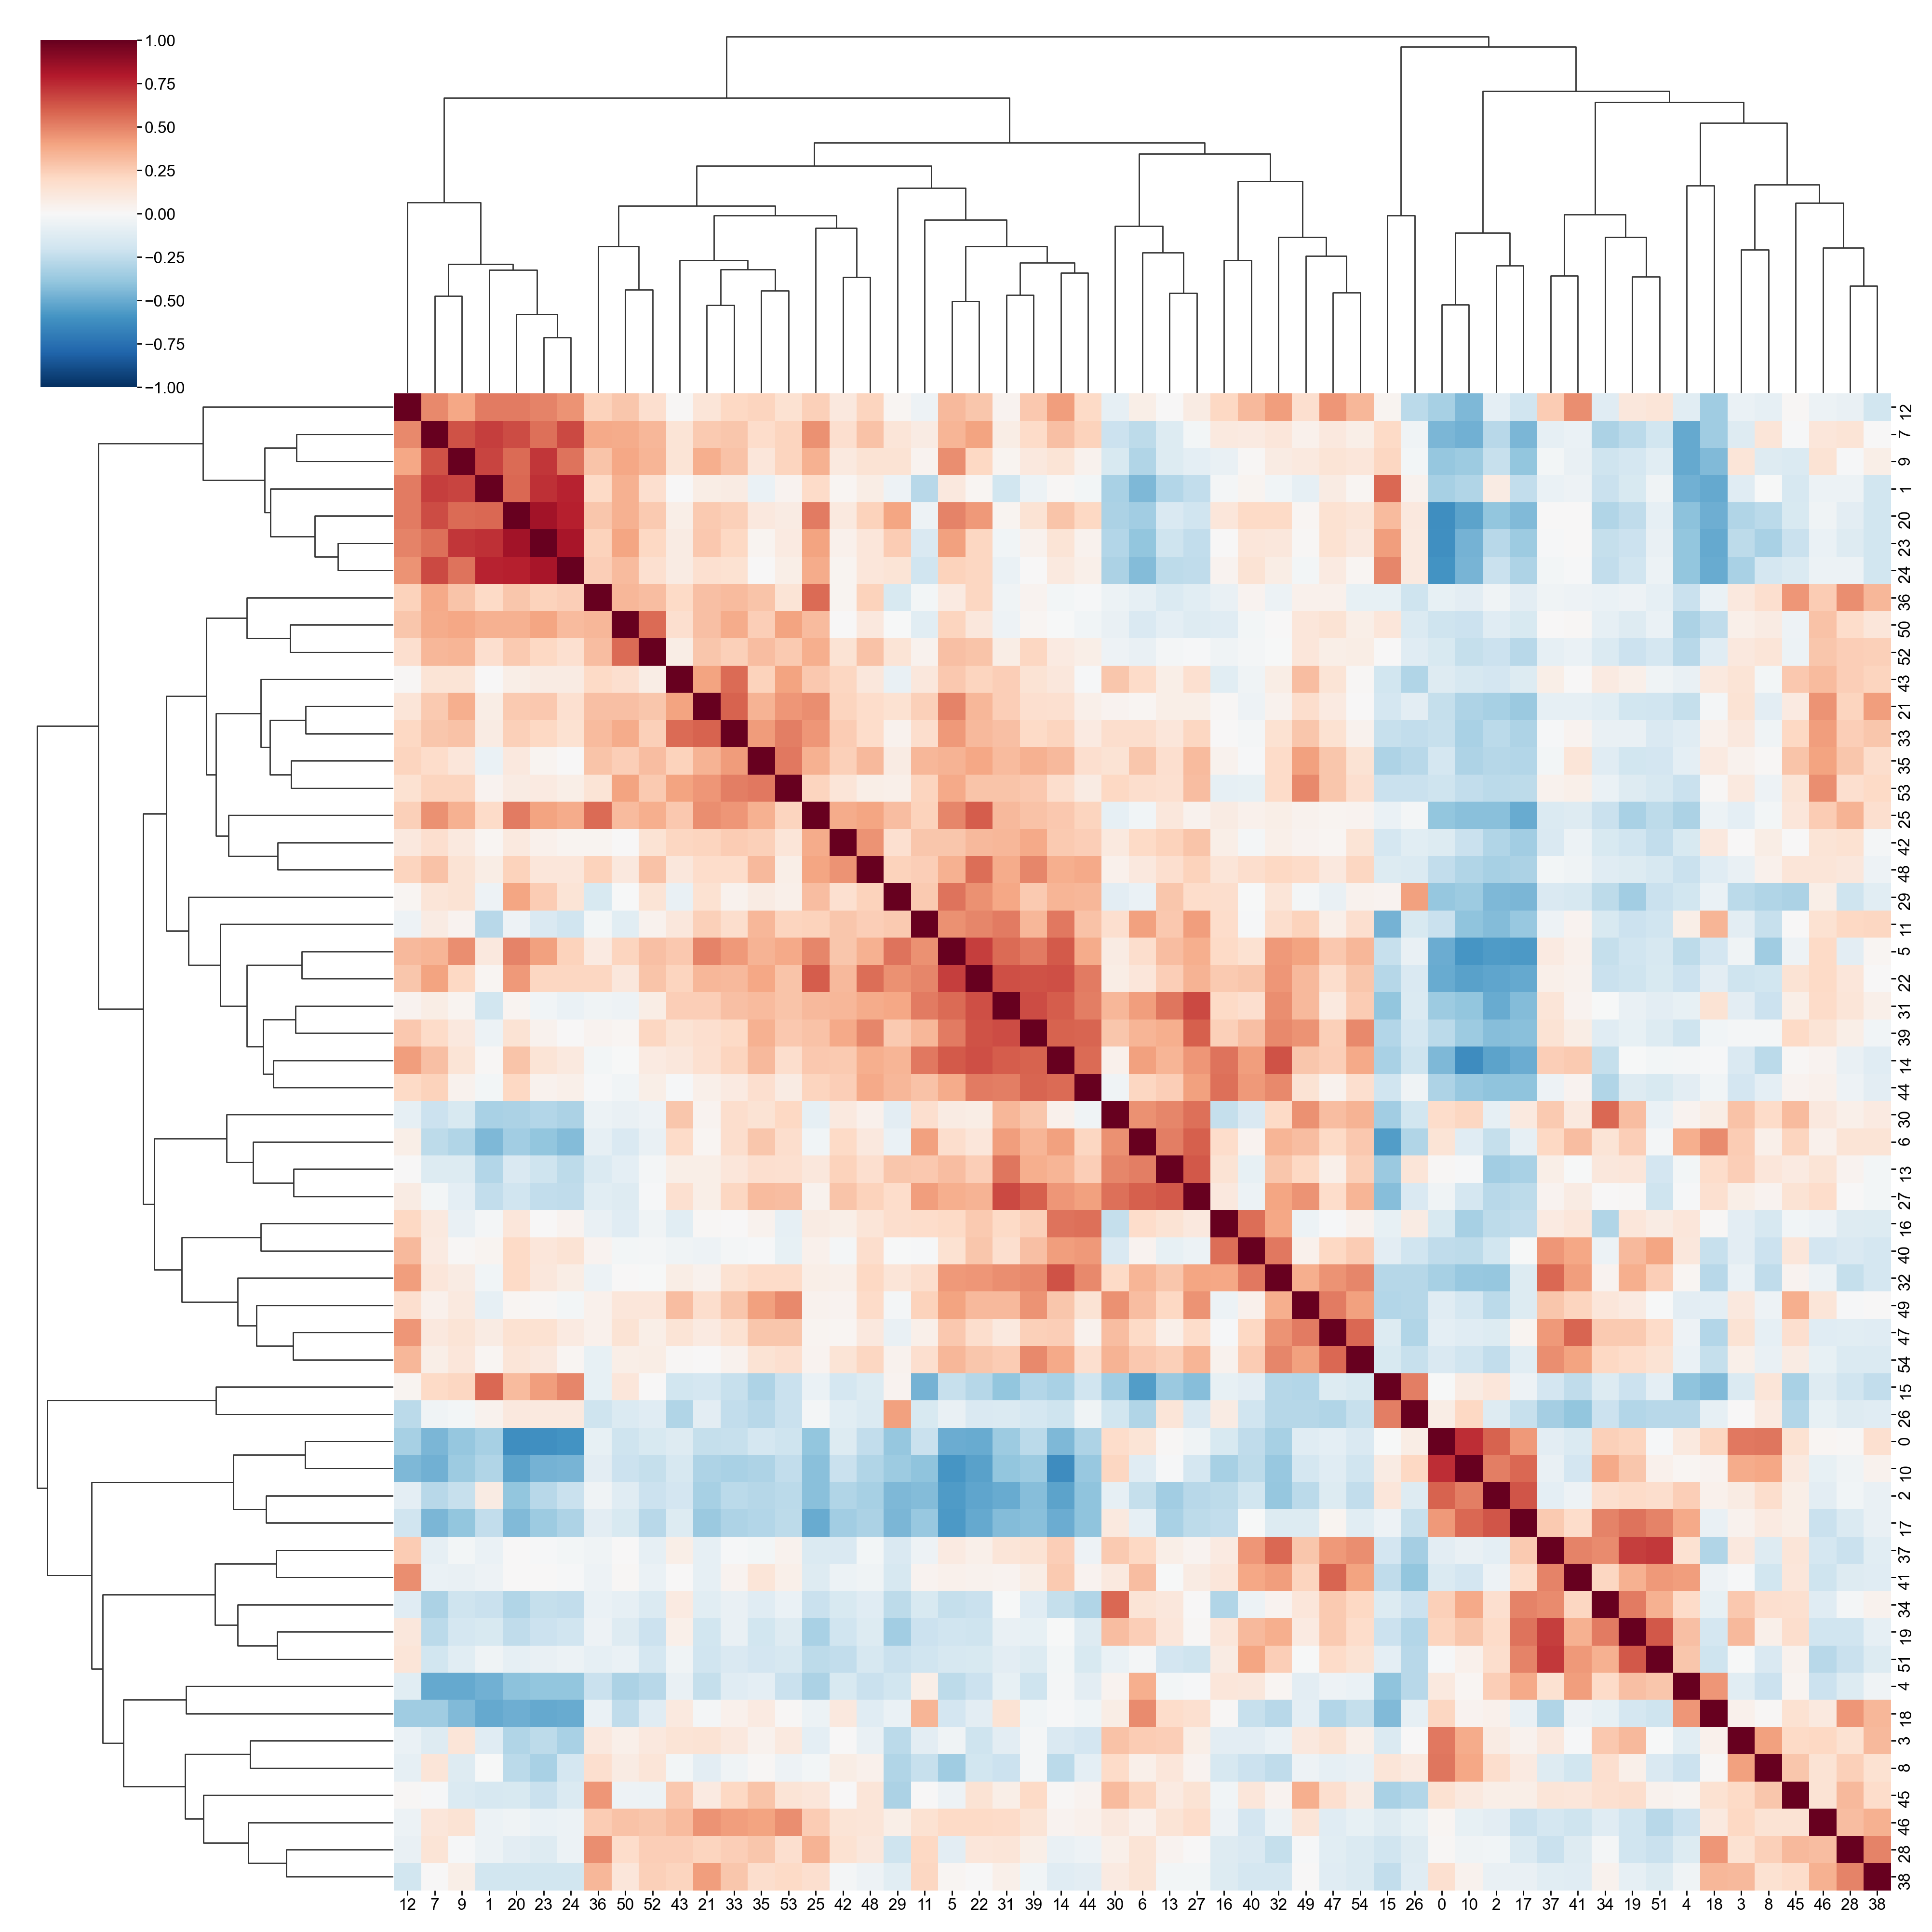

In [26]:
sns.clustermap(df.iloc[:, :n_syllables].corr(), cmap='RdBu_r', vmin=-1)

In [5]:
pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_mouse_area_df_v00.parquet'
size_df = pd.read_parquet(pth)

In [6]:
sizes_col = size_df.groupby('age')['quant_0.5'].transform(demean)
# sizes_col = size_df.groupby('age')['quant_0.5'].transform(zscore)
# sizes_col = size_df['quant_0.5']
sizes_col = sizes_col.loc[df.index]

## Run held-out fitting to determine number of splines

In [50]:
use_log_age = False
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=130, log_transform=use_log_age
)
age_samples = np.linspace(0, 1, 500)
age_sd = age_normalizer(10)

keep_syllables = 20
n_sessions = len(syllable_counts_jax)

hypparams = {
    "age_sd": age_sd,
    "params_sd": 0.3,
}

pbar = tqdm(range(4, 9, 1))

out_ll = {}

for n_splines in pbar:
    rng = np.random.RandomState(3)
    spline_class, splines = create_splines(age_samples, df=n_splines)

    params = fit_params(
        syllable_counts_jax, n_splines, age, age_samples, age_normalizer, n_syllables
    )

    lls = []
    for i in range(20):
        hypparams["mask"], hypparams["heldout_mask"] = create_masks(
            keep_syllables, n_syllables, n_sessions, rng
        )
        ll_fun = partial(
            neg_log_likelihood,
            bases=splines,
            age_samples=age_samples,
            true_age=age_normalizer(age),
            counts=syllable_counts_jax + 1,
            hypparams=hypparams,
            heldout=False,
        )
        optimized_params, loss = optimize(params, ll_fun, lr=0.2, n_iter=60)

        heldout_nll = neg_log_likelihood(
            optimized_params,
            splines,
            age_samples,
            age_normalizer(age),
            syllable_counts_jax + 1,
            hypparams=hypparams,
            heldout=True,
        )
        out_ll[(n_splines, i)] = -heldout_nll
        lls.append(-heldout_nll)

  0%|          | 0/5 [00:00<?, ?it/s]

In [51]:
heldout_ll_df = (
    pd.DataFrame(valmap(lambda v: v.item(), out_ll), index=[0])
    .rename_axis(["n_splines", "fold"], axis=1)
    .melt(value_name="log_likelihood")
)

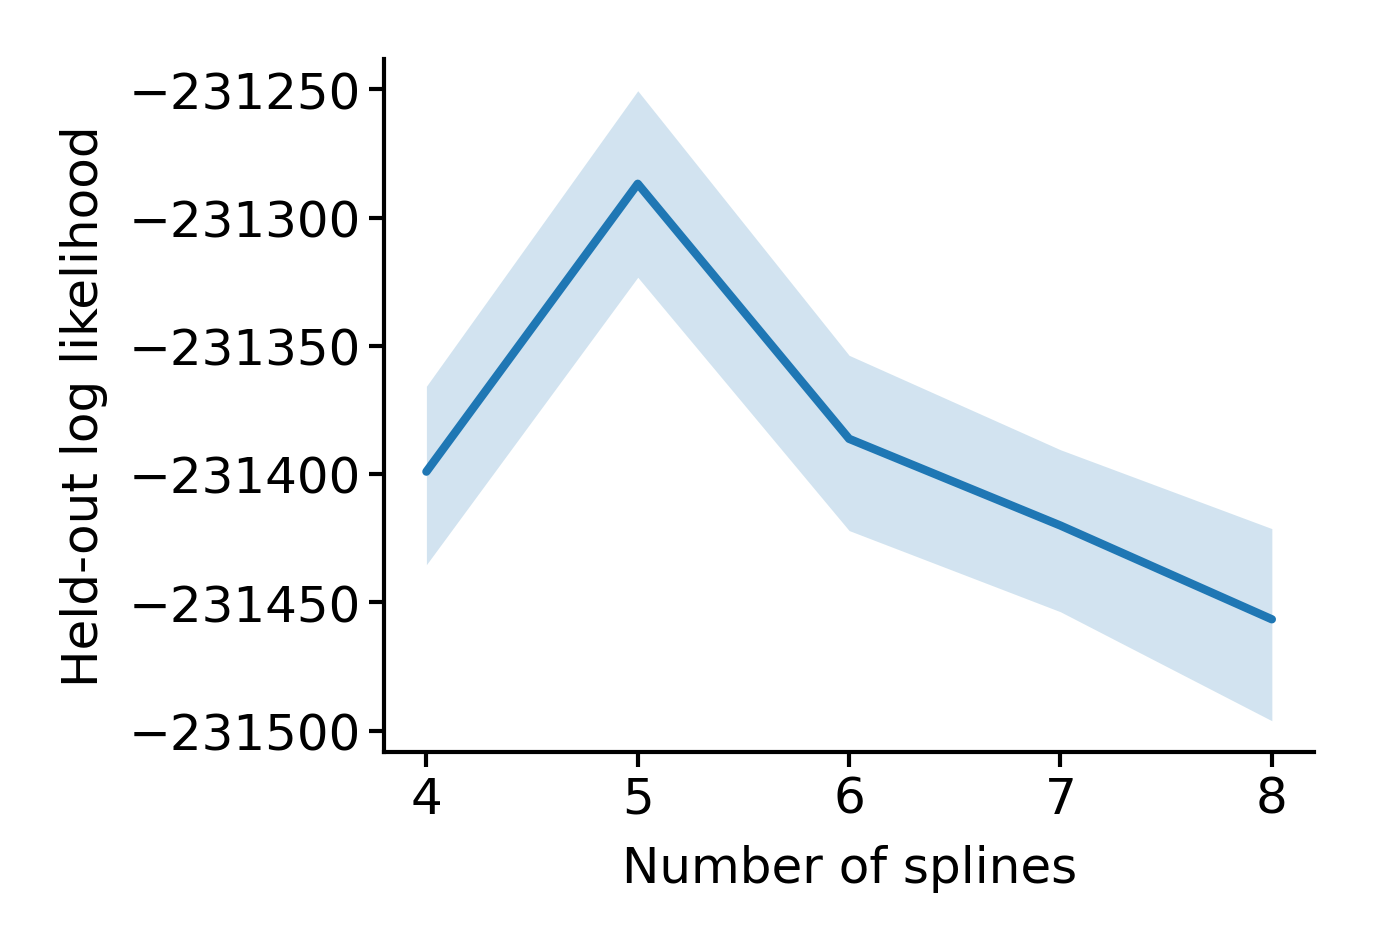

In [52]:
fig = figure(2, 1.5)
ax = sns.lineplot(data=heldout_ll_df, x="n_splines", y="log_likelihood", err_kws=dict(lw=0))
ax.set(xlabel="Number of splines", ylabel="Held-out log likelihood")
sns.despine()

In [33]:
heldout_ll_df.groupby("n_splines")["log_likelihood"].mean().sort_values(ascending=False)

n_splines
5   -231273.175000
6   -231378.367188
4   -231397.559375
7   -231404.815625
8   -231457.532812
Name: log_likelihood, dtype: float64

In [14]:
bio_age = jnp.exp(optimized_params['basis_weights']) @ splines
distribution = tfp.distributions.DirichletMultinomial(
    total_count=syllable_counts_jax.sum(axis=1)[:, None],
    concentration=jnp.swapaxes(bio_age[:, ::4][None], 1, 2)
)
syllable_samples = distribution.sample(seed=jax.random.PRNGKey(0))

bio_ages = get_biological_age(
    optimized_params,
    splines,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams,
    age_unnormalizer,
)

In [ ]:
plot_syllables = 6
x = age_unnormalizer(age_samples[::4])

fig, ax = plt.subplots(
    plot_syllables, 2, figsize=(3.25, 1.2 * plot_syllables), sharex=True, sharey=False
)
for syllable in range(plot_syllables):
    avg_sample = syllable_samples[..., syllable].mean(0)
    a = ax[syllable, 0]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        age, syllable_counts_jax[:, syllable], "o", label="Data", alpha=0.6, mew=0, ms=3
    )
    a.set(title=f"Syllable {syllable}", xlabel="Age (weeks)", ylabel="Syllable counts")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
    a = ax[syllable, 1]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        bio_ages,
        syllable_counts_jax[:, syllable],
        "o",
        label="Bio ages",
        alpha=0.6,
        mew=0,
        ms=3,
        c="C2",
    )
    a.set(xlabel="Biological age (weeks)")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
sns.despine()
fig.tight_layout()

## Test feature importance code with just bio age

In [56]:
use_log_age = False
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=130, log_transform=use_log_age
)
age_samples = np.linspace(0, 1, 1000)
age_sd = age_normalizer(10)

hypparams = {
    "age_sd": age_sd,
    "params_sd": 0.3,
}
n_splines = 5

spline_class, splines = create_splines(age_samples, df=n_splines)
params = fit_params(syllable_counts_jax, n_splines, age, age_samples, age_normalizer, n_syllables)

ll_fun = partial(
    neg_log_likelihood,
    bases=splines,
    age_samples=age_samples,
    true_age=age_normalizer(age),
    counts=syllable_counts_jax + 1,
    hypparams=hypparams,
    heldout=False,
)
optimized_params, loss = optimize(params, ll_fun, lr=0.2, n_iter=150)

heldout_nll = neg_log_likelihood(
    optimized_params,
    splines,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams=hypparams,
    heldout=True,
)

In [57]:
bio_ages = get_biological_age(
    optimized_params,
    splines,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams,
    age_unnormalizer,
)

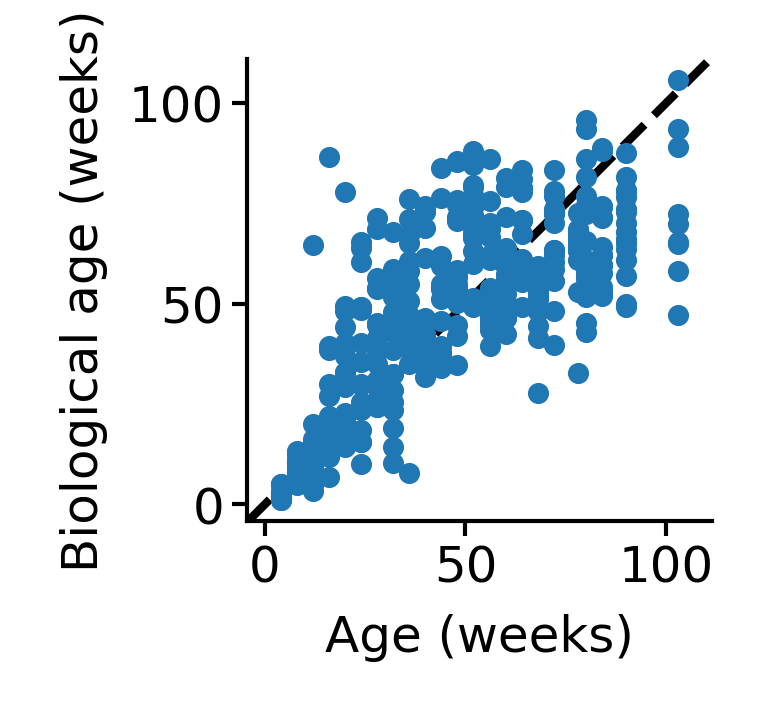

In [58]:
fig = figure(1, 1)
plt.scatter(age, bio_ages, s=3)
plt.xlabel("Age (weeks)")
plt.ylabel("Biological age (weeks)")
add_identity(fig.gca(), c='k', ls='--', zorder=-1)
plt.axis('equal')
sns.despine()

In [59]:
local_d = compute_local_derivative(bio_ages, age_normalizer, optimized_params, n_splines)

Text(0, 0.5, 'syllables')

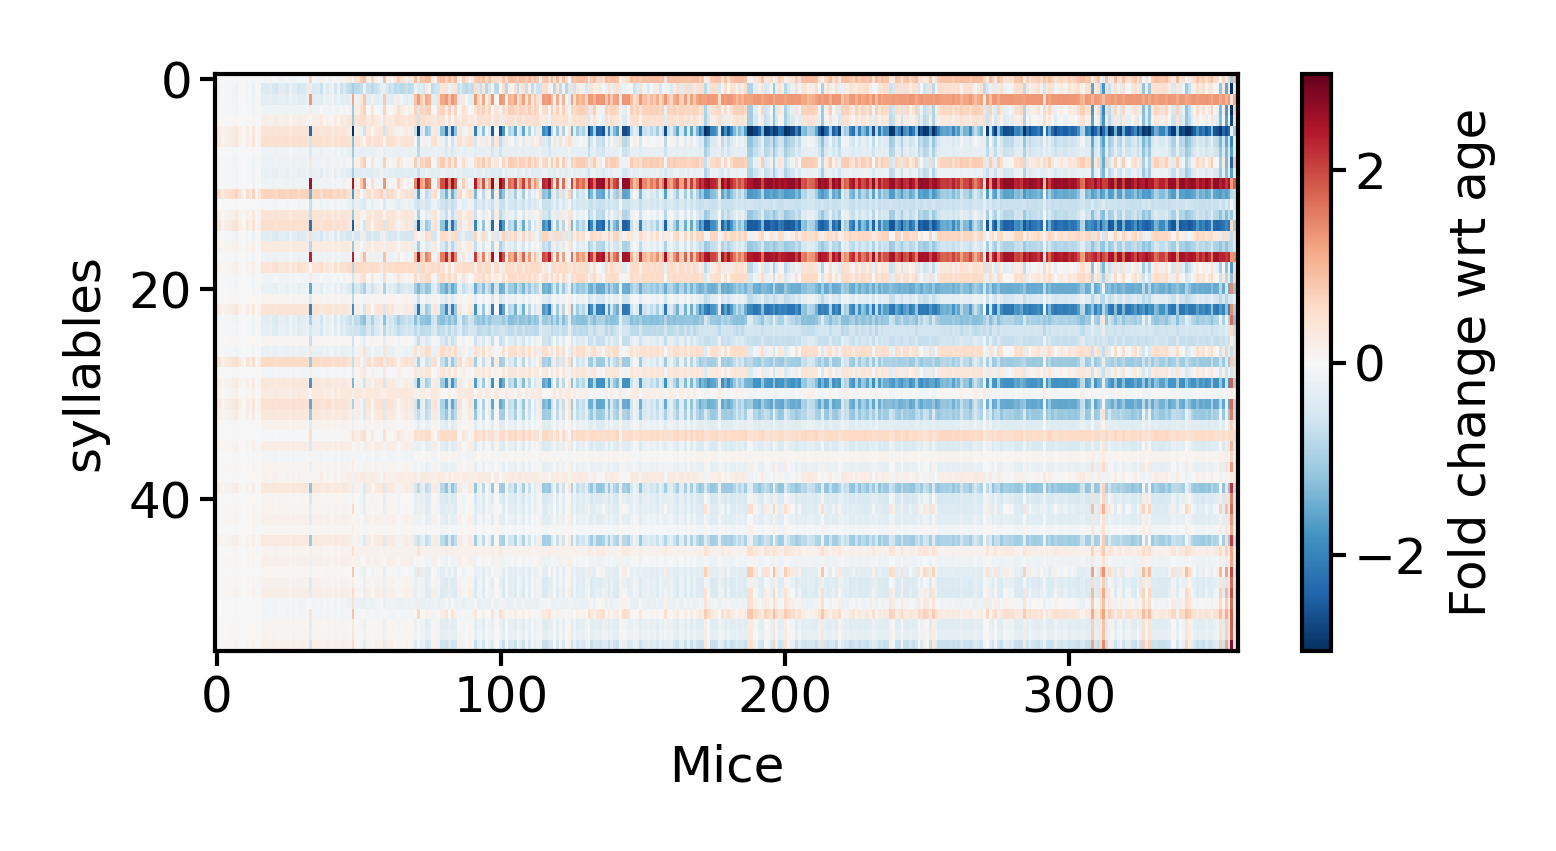

In [60]:
mag = 3
figure(2.75, 1.25)
plt.imshow(
    local_d.T, vmin=-mag, vmax=mag, cmap="RdBu_r", aspect="auto", interpolation="none"
)
plt.colorbar(label="Fold change wrt age")
plt.xlabel("Mice")
plt.ylabel("syllables")

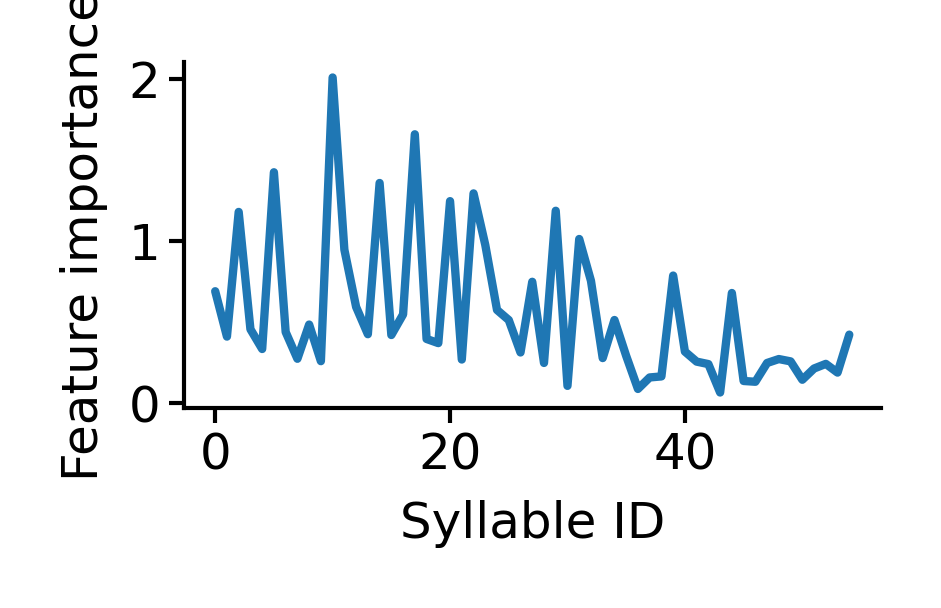

In [61]:
figure(1.5, 0.75)
plt.plot(np.median(np.abs(local_d), axis=0))
plt.ylabel("Feature importance")
plt.xlabel("Syllable ID")
sns.despine()

## Add mouse size into fitting procedure

In [32]:
use_log_age = False
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=130, log_transform=use_log_age
)
size_normalizer, size_unnormalizer = age_normalizer_factory(
    min_age=sizes_col.min(), max_age=sizes_col.max(), log_transform=False
)
age_samples = np.linspace(0, 1, 500)
age_sd = age_normalizer(10)

keep_syllables = 20
n_sessions = len(syllable_counts_jax)

# n_size_splines = 5
n_splines = 5

hypparams = {
    "age_sd": age_sd,
    "bio_params_sd": 0.3,
    "size_params_sd": 0.3,
}

spline_class, splines = create_splines(age_samples, df=n_splines)

# adding in size
sizes = size_normalizer(sizes_col.to_numpy())

pbar = tqdm(range(4, 9, 1))

out_ll = {}

for n_size_splines in pbar:
    rng = np.random.RandomState(3)
    spline_class, _ = create_splines(age_samples, df=n_size_splines)
    size_splines = spline_class.transform(sizes).T

    params = fit_params_v2(
        syllable_counts_jax,
        n_splines,
        age,
        n_size_splines,
        n_syllables,
        age_samples,
        age_normalizer,
    )

    basis_dict = {"bio": splines, "size": size_splines}

    lls = []
    for i in range(20):
        hypparams["mask"], hypparams["heldout_mask"] = create_masks(
            keep_syllables, n_syllables, n_sessions, rng
        )
        ll_fun = partial(
            neg_log_likelihood_v2,
            bases=basis_dict,
            age_samples=age_samples,
            true_age=age_normalizer(age),
            counts=syllable_counts_jax + 1,
            hypparams=hypparams,
            heldout=False,
        )
        optimized_params, loss = optimize(params, ll_fun, lr=0.2, n_iter=60)

        heldout_nll = neg_log_likelihood_v2(
            optimized_params,
            basis_dict,
            age_samples,
            age_normalizer(age),
            syllable_counts_jax + 1,
            hypparams=hypparams,
            heldout=True,
        )
        out_ll[(n_splines, n_size_splines, i)] = -heldout_nll
        lls.append(-heldout_nll)

  0%|          | 0/5 [00:00<?, ?it/s]

In [33]:
size_heldout_ll_df = (
    pd.DataFrame(valmap(lambda v: v.item(), out_ll), index=[0])
    .rename_axis(["n_splines", "n_size_splines", "fold"], axis=1)
    .melt(value_name="log_likelihood")
)

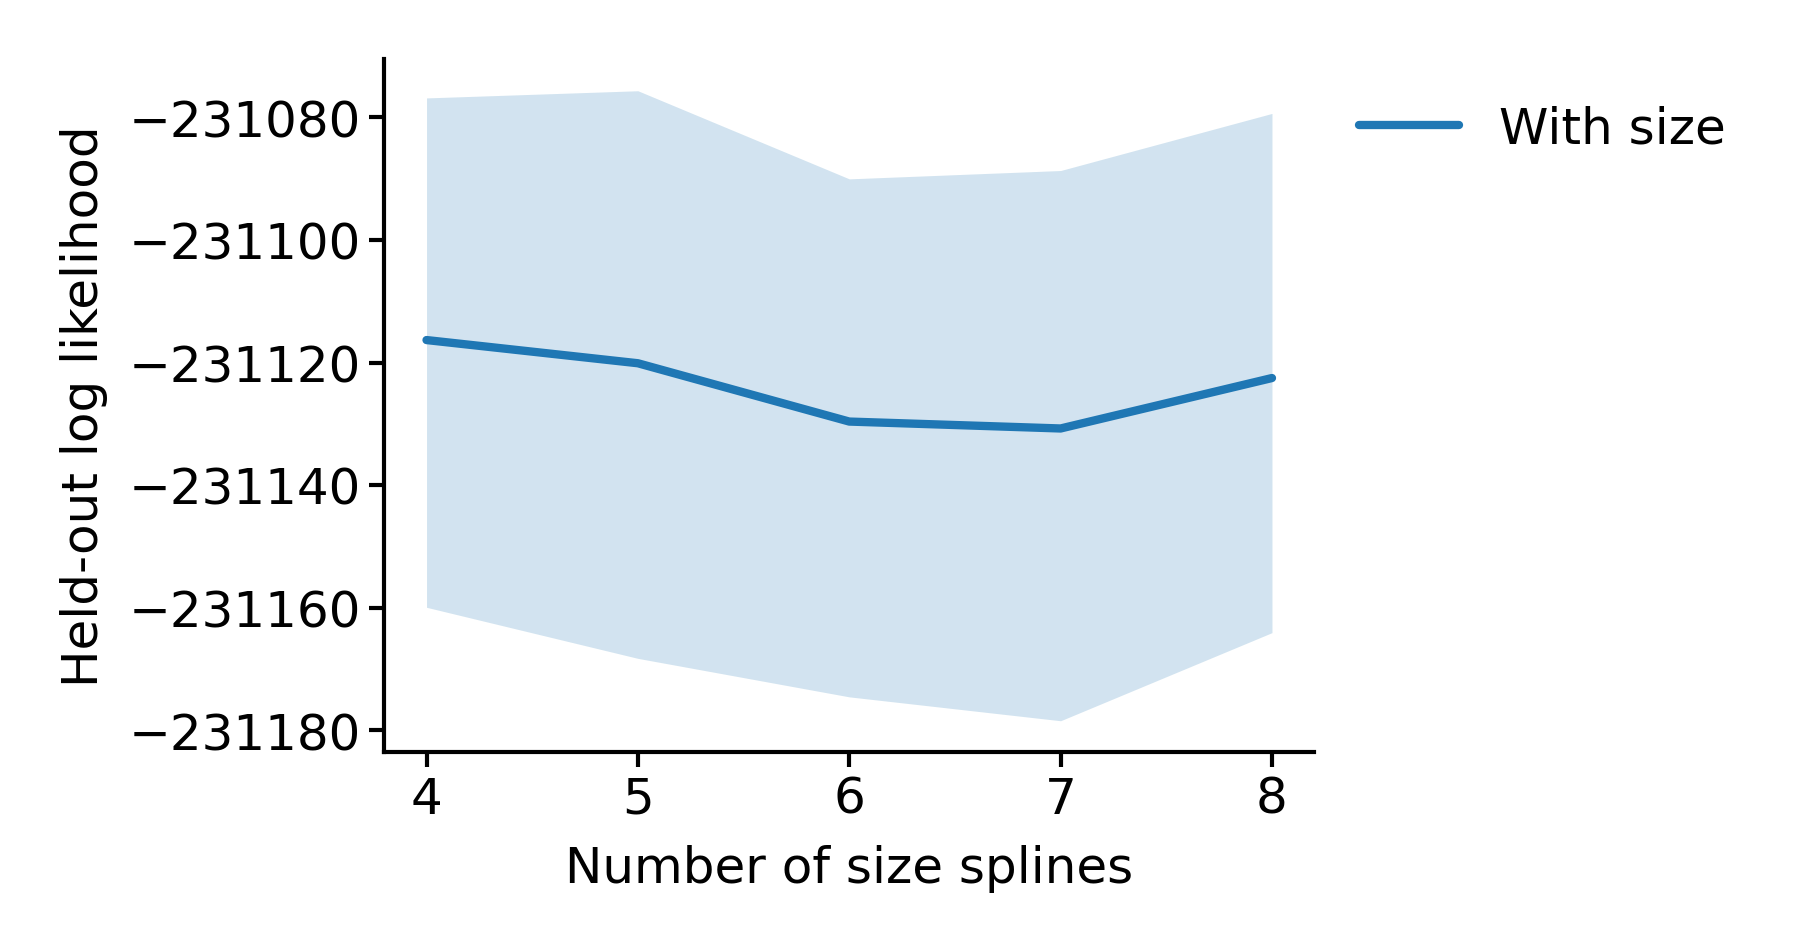

In [34]:
fig = figure(2, 1.5)
ax = sns.lineplot(
    data=size_heldout_ll_df,
    x="n_size_splines",
    y="log_likelihood",
    err_kws=dict(lw=0),
    label="With size",
)
ax.set(xlabel="Number of size splines", ylabel="Held-out log likelihood")
legend()
sns.despine()

In [35]:
size_heldout_ll_df.groupby("n_size_splines")["log_likelihood"].mean().sort_values(ascending=False)

n_size_splines
4   -231116.327344
5   -231120.110937
8   -231122.522656
6   -231129.624219
7   -231130.753125
Name: log_likelihood, dtype: float64

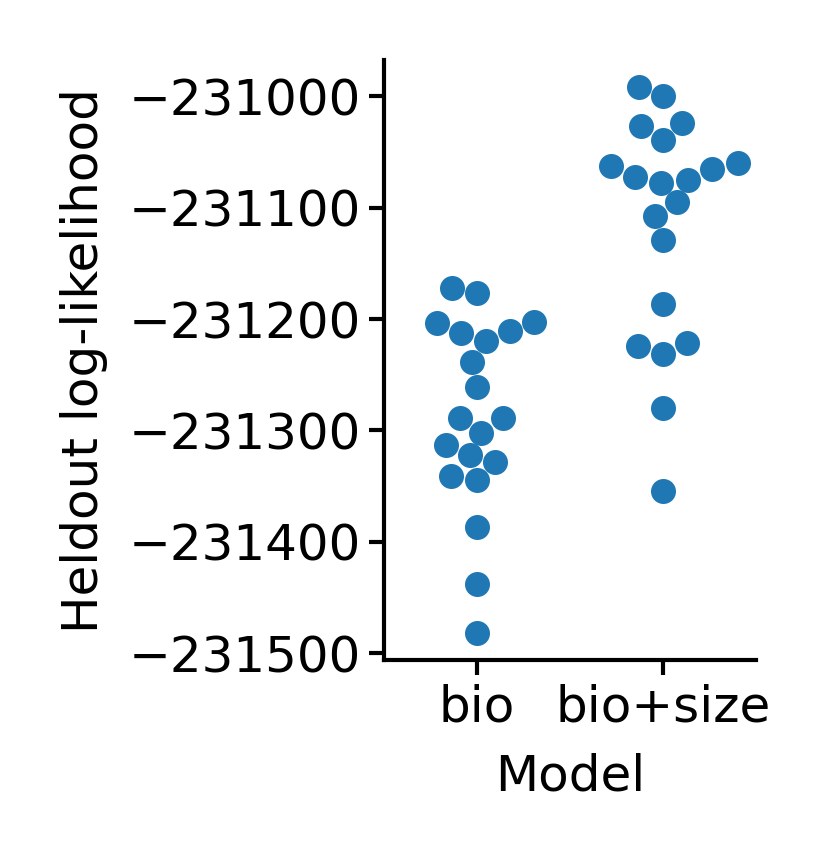

In [63]:
tmp = heldout_ll_df.query("n_splines == 5").copy()
tmp['type'] = 'bio'
tmp2 = size_heldout_ll_df.query("n_size_splines == 4").copy()
tmp2['type'] = 'bio+size'

fig = figure(0.8, 1.3)
ax = sns.swarmplot(data=pd.concat([tmp, tmp2]), x='type', y='log_likelihood', size=3)
ax.set(ylabel="Heldout log-likelihood", xlabel="Model")
sns.despine()

In [ ]:
fig = figure(2, 1.5)
ax = sns.lineplot(
    data=heldout_ll_df,
    x="n_splines",
    y="log_likelihood",
    err_kws=dict(lw=0),
    label="Without size",
)
ax = sns.lineplot(
    data=size_heldout_ll_df,
    x="n_splines",
    y="log_likelihood",
    err_kws=dict(lw=0),
    label="With size",
)
ax.set(xlabel="Number of splines", ylabel="Held-out log likelihood")
legend()
sns.despine()

## Test feature importance code

In [64]:
use_log_age = False
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=130, log_transform=use_log_age
)
size_normalizer, size_unnormalizer = age_normalizer_factory(
    min_age=sizes_col.min(), max_age=sizes_col.max(), log_transform=False
)
age_samples = np.linspace(0, 1, 500)
age_sd = age_normalizer(10)

n_size_splines = 4
n_splines = 5

hypparams = {
    "age_sd": age_sd,
    "bio_params_sd": 0.3,
    "size_params_sd": 0.3,
}

# adding in size
sizes = size_normalizer(sizes_col.to_numpy())
spline_class, _ = create_splines(age_samples, df=n_size_splines)
size_splines = spline_class.transform(sizes).T

out_ll = {}

spline_class, splines = create_splines(age_samples, df=n_splines)

params = fit_params_v2(
    syllable_counts_jax,
    n_splines,
    age,
    n_size_splines,
    n_syllables,
    age_samples,
    age_normalizer,
)

basis_dict = {"bio": splines, "size": size_splines}

ll_fun = partial(
    neg_log_likelihood_v2,
    bases=basis_dict,
    age_samples=age_samples,
    true_age=age_normalizer(age),
    counts=syllable_counts_jax + 1,
    hypparams=hypparams,
    heldout=False,
)
optimized_params, loss = optimize(params, ll_fun, lr=0.2, n_iter=150)

heldout_nll = neg_log_likelihood_v2(
    optimized_params,
    basis_dict,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams=hypparams,
    heldout=True,
)

In [38]:
bio_ages = get_biological_age_v2(
    optimized_params,
    basis_dict,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams,
    age_unnormalizer,
)

In [39]:
local_d = compute_local_derivative_v2(bio_ages, sizes, age_normalizer, optimized_params, n_splines, n_size_splines)

### With jax gradients

In [40]:
mags = np.median(np.abs(local_d), axis=0)

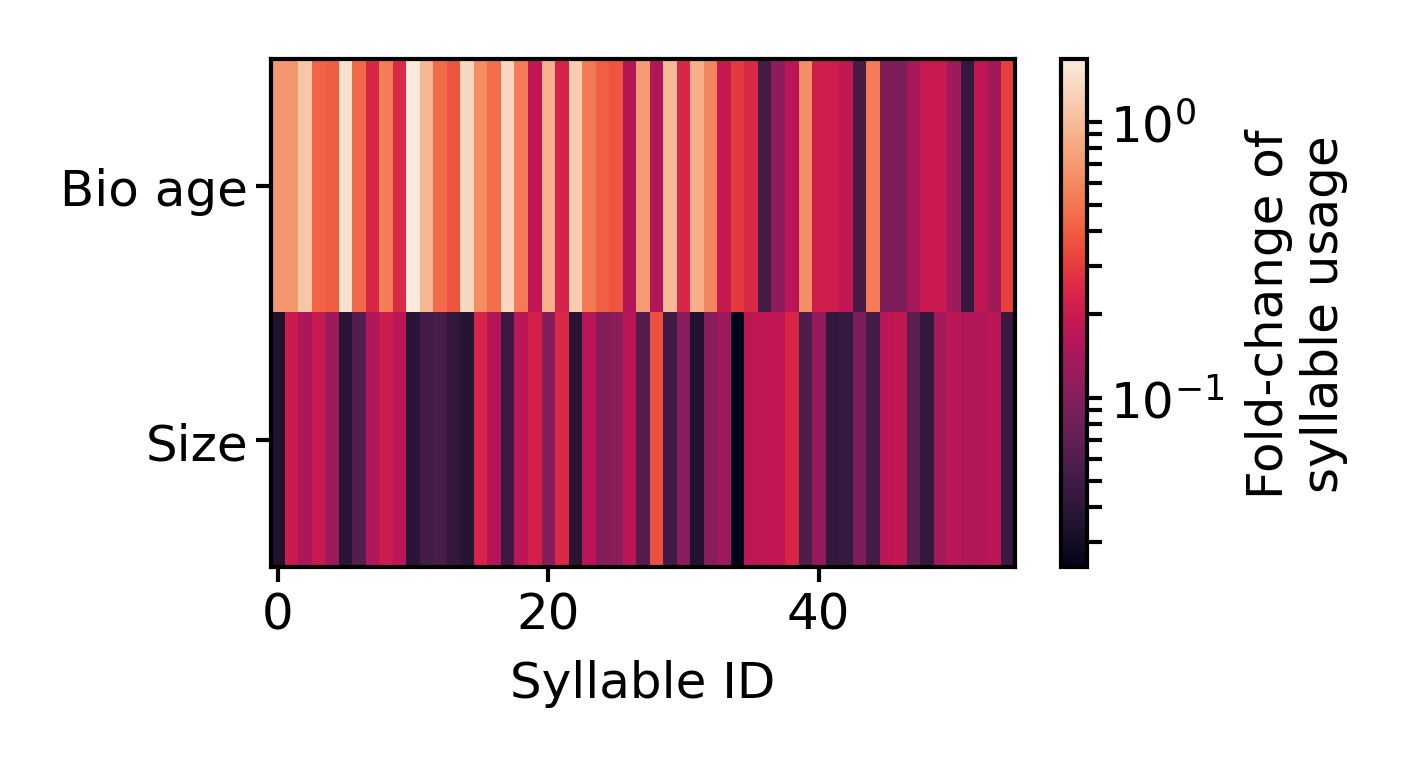

In [49]:
fig = figure(2, 1.1)
plt.imshow(mags.T, aspect='auto', norm="log")
plt.yticks([0, 1], labels=["Bio age", "Size"])
plt.xlabel("Syllable ID")
plt.colorbar(label="Fold-change of\nsyllable usage")

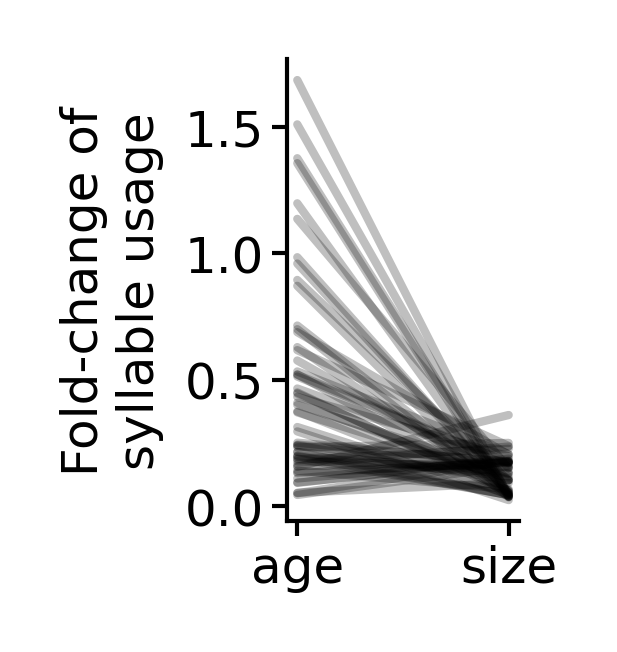

In [47]:
fig = figure(0.5, 1)
for line in mags:
    plt.plot([0, 1], line, c='k', alpha=0.25)
plt.xticks([0, 1], ["age", "size"])
plt.ylabel("Fold-change of\nsyllable usage")
sns.despine()

Text(0, 0.5, 'syllables')

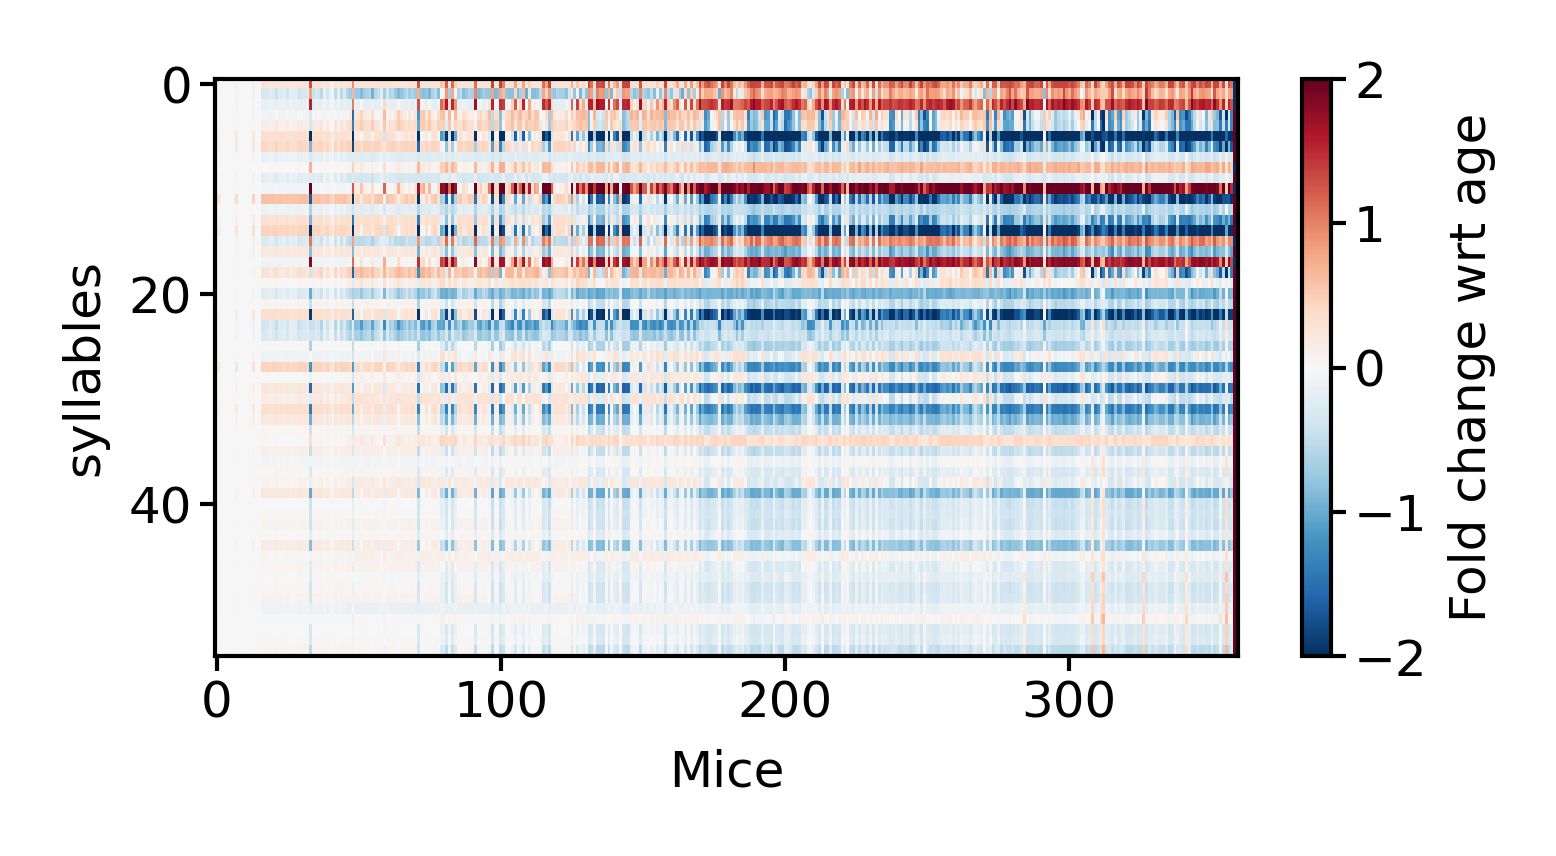

In [44]:
figure(2.75, 1.25)
mag = 2.0
plt.imshow(
    local_d[..., 0].T, vmin=-mag, vmax=mag, cmap="RdBu_r", aspect="auto", interpolation="none"
)
plt.colorbar(label="Fold change wrt age")
plt.xlabel("Mice")
plt.ylabel("syllables")

Text(0, 0.5, 'syllables')

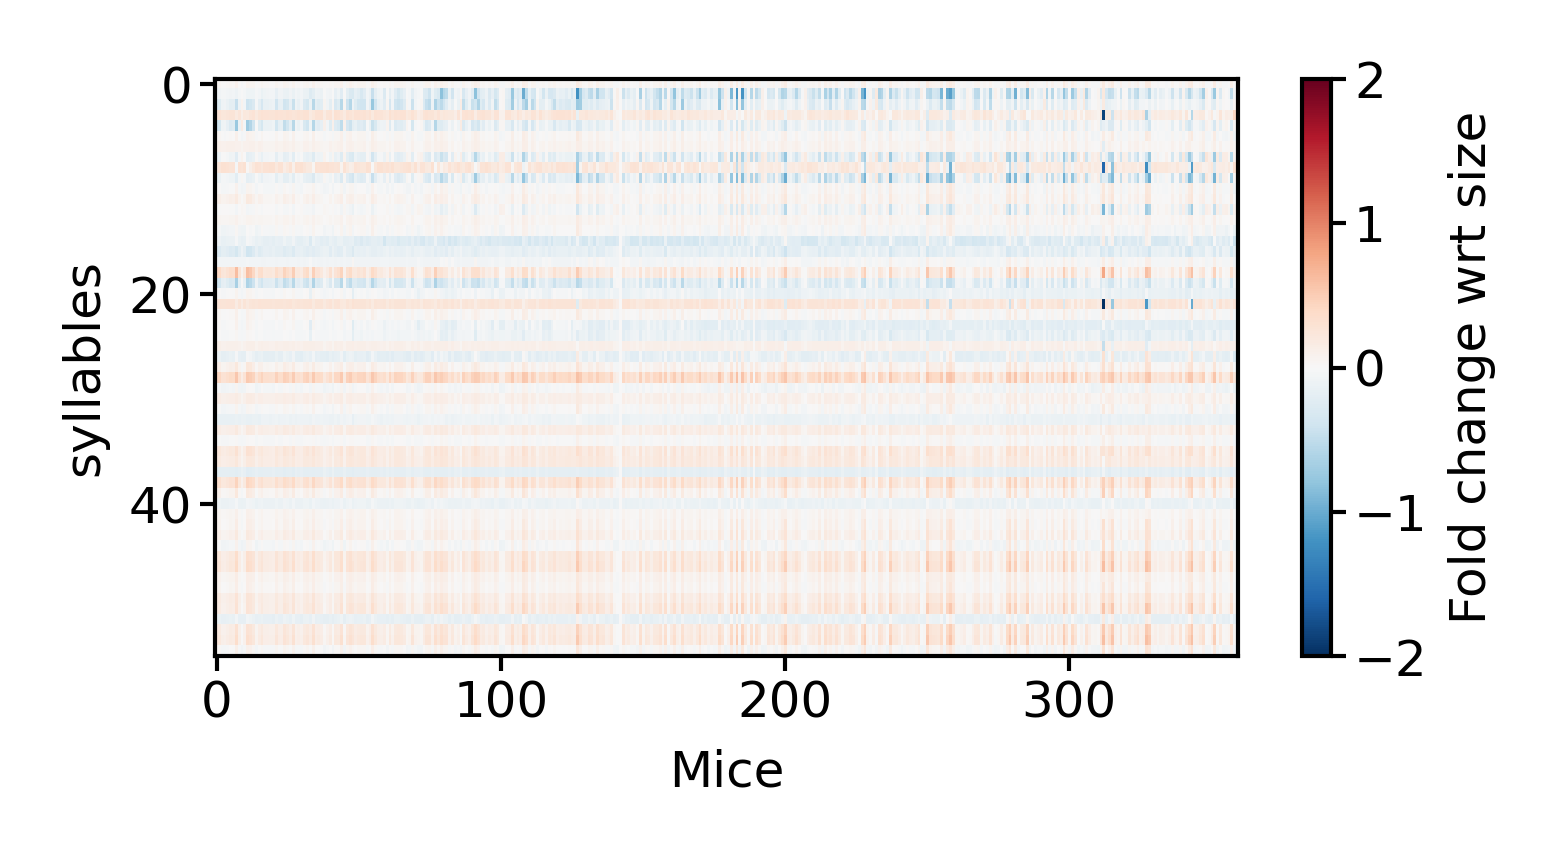

In [45]:
figure(2.75, 1.25)
plt.imshow(
    local_d[..., 1].T, vmin=-mag, vmax=mag, cmap="RdBu_r", aspect="auto", interpolation="none"
)
plt.colorbar(label="Fold change wrt size")
plt.xlabel("Mice")
plt.ylabel("syllables")

## Run for individuality

In [4]:
df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_relabeled_counts_matrix_v00.parquet"
)
df = df.sort_index(axis=1)
mask = df.index.get_level_values("age") < 100
df = df[mask].copy()

n_syllables = 55
age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))[:, :n_syllables]

size_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_mouse_area_df_v00.parquet')

# sizes_col = size_df.groupby('age')['quant_0.5'].transform(demean)
# sizes_col = size_df.groupby('age')['quant_0.5'].transform(zscore)
sizes_col = size_df['quant_0.5']
sizes_col = sizes_col.loc[df.index]

sizes_col.loc[sizes_col == 0] = np.nan
sizes_col = sizes_col.groupby('mouse').apply(lambda df: df.sort_index(level='age').interpolate()).droplevel(0)

sizes_col = sizes_col.loc[df.index]

In [5]:
label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
mouse_ids = label_encoder.fit_transform(
    sizes_col.index.get_level_values("mouse").to_numpy()[:, None]
).T

In [6]:
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=85, log_transform=False
)
size_normalizer, size_unnormalizer = age_normalizer_factory(
    min_age=sizes_col.min(), max_age=sizes_col.max(), log_transform=False
)
age_samples = np.linspace(0, 1, 500)
age_sd = age_normalizer(10)

n_size_splines = 5
n_splines = 5

hypparams = {
    "age_sd": age_sd,
    "bio_params_sd": 0.3,
    "size_params_sd": 0.3,
}

# adding in size
sizes = size_normalizer(sizes_col.to_numpy())
spline_class, _ = create_splines(age_samples, df=n_size_splines)
size_splines = spline_class.transform(sizes).T

out_ll = {}

spline_class, splines = create_splines(age_samples, df=n_splines)

params = fit_params_v3(
    syllable_counts_jax,
    n_splines,
    age,
    n_size_splines,
    n_syllables,
    len(mouse_ids),
    age_samples,
    age_normalizer,
)

basis_dict = {"bio": splines, "size": size_splines, "individual": jnp.array(mouse_ids)}

ll_fun = partial(
    neg_log_likelihood_v3,
    bases=basis_dict,
    age_samples=age_samples,
    true_age=age_normalizer(age),
    counts=syllable_counts_jax + 1,
    hypparams=hypparams,
    heldout=False,
)
optimized_params, loss = optimize(params, ll_fun, lr=0.2, n_iter=150)

heldout_nll = neg_log_likelihood_v3(
    optimized_params,
    basis_dict,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams=hypparams,
    heldout=True,
)

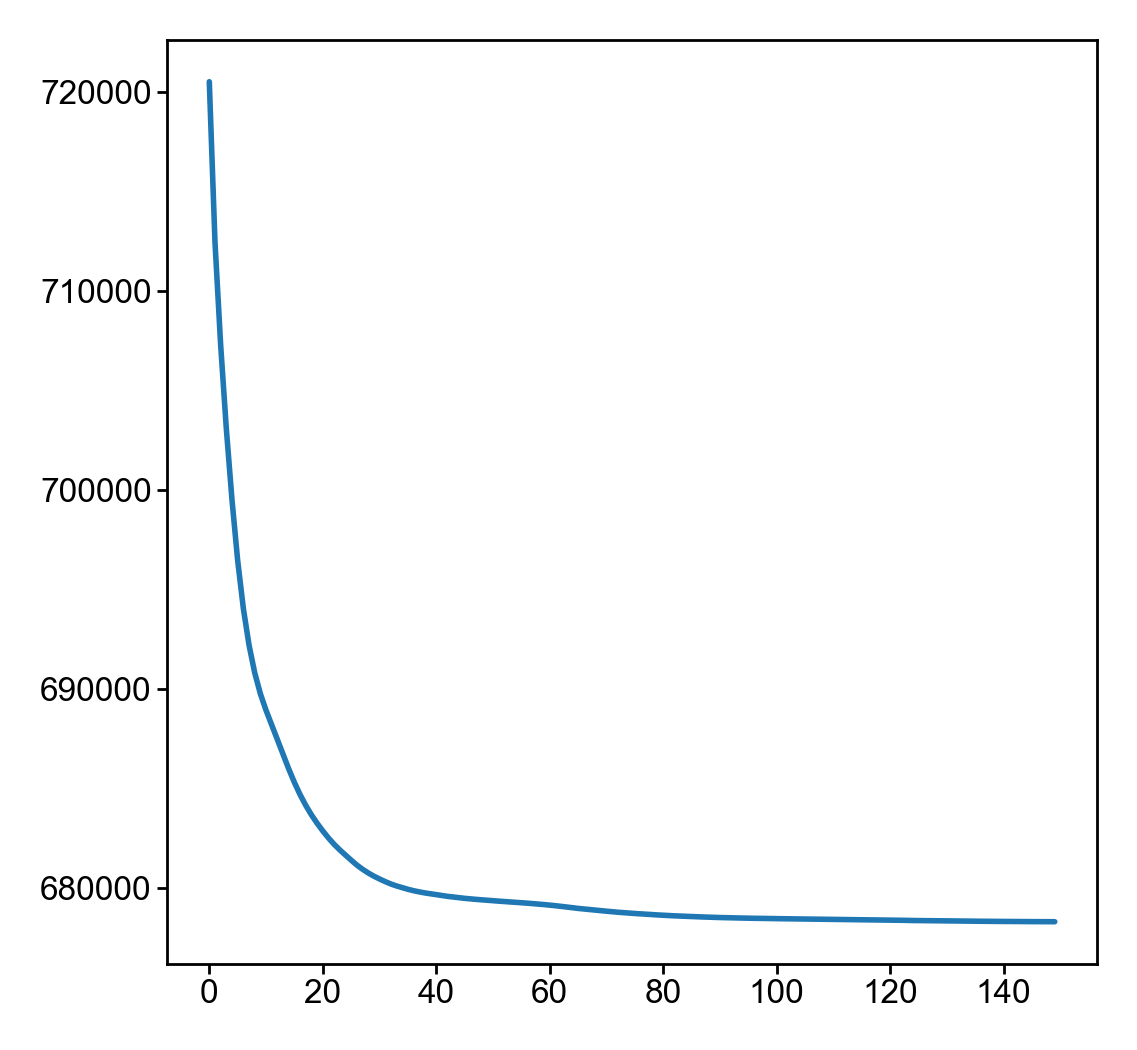

In [7]:
plt.plot(loss)

In [8]:
list(optimized_params)

['bio_basis_weights', 'individual_biases', 'size_basis_weights']

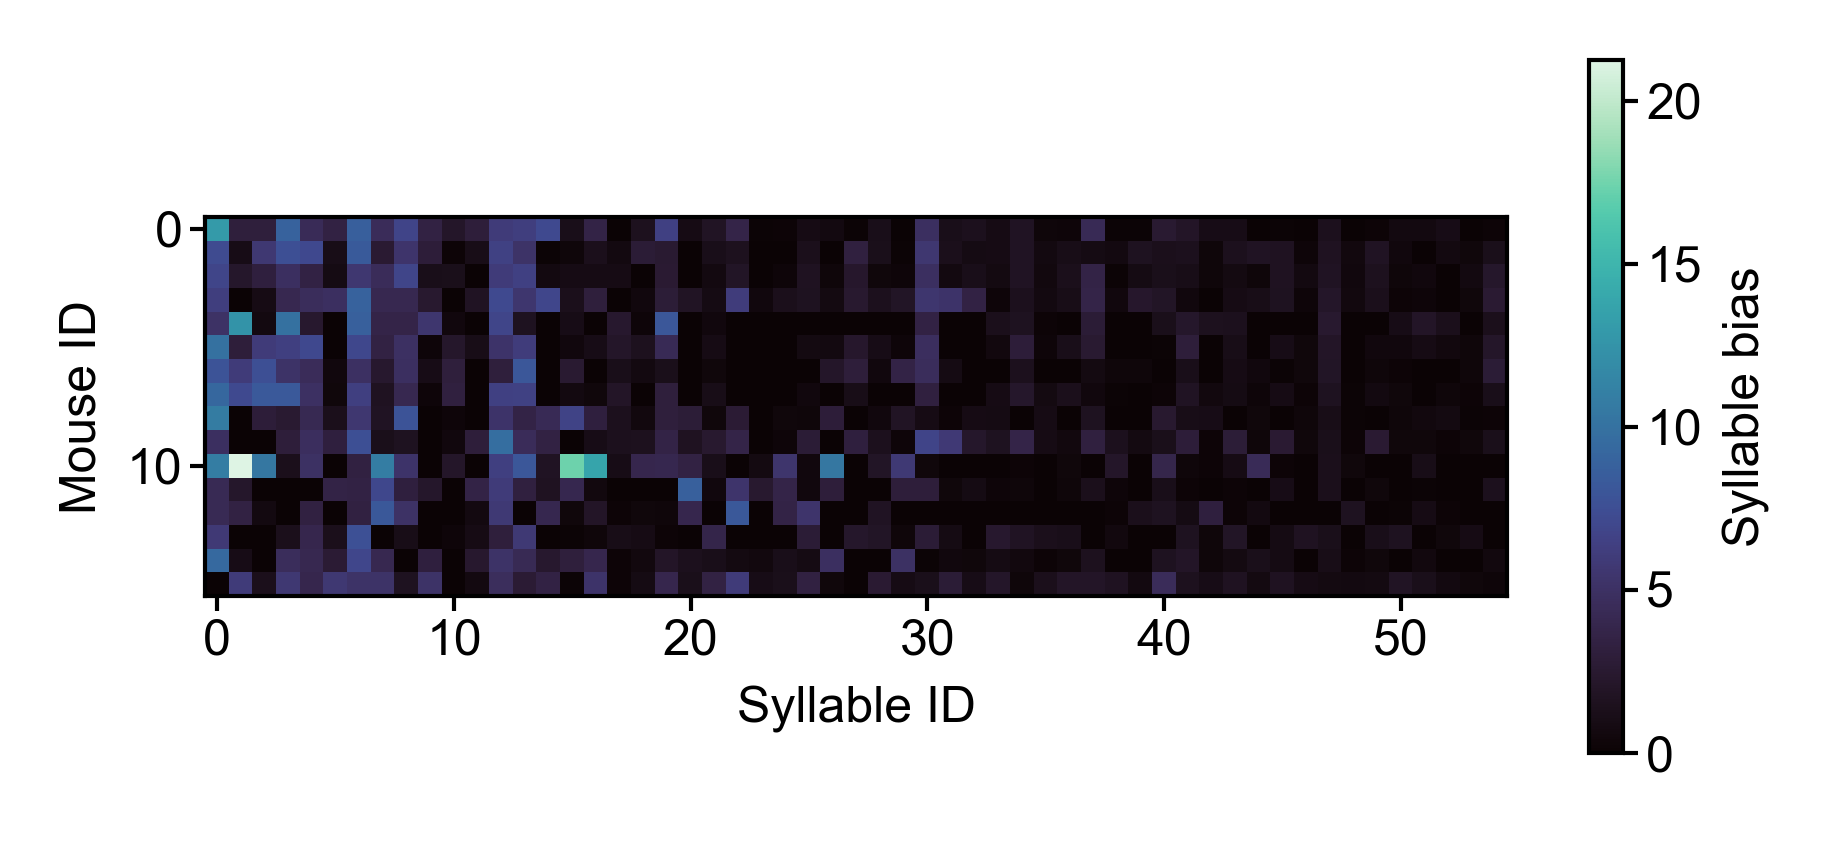

In [9]:
fig = figure(3.5, 1.5)
ax = fig.gca()
im = ax.imshow(jnp.exp(optimized_params['individual_biases']).T, cmap="mako", vmin=0)
ax.set(xlabel="Syllable ID", ylabel="Mouse ID")
fig.colorbar(im, label="Syllable bias")

In [10]:
mouse_bias = np.array(jnp.exp(optimized_params["individual_biases"]))
mouse_bias = pd.DataFrame(
    mouse_bias,
    columns=label_encoder.categories_,
    index=pd.Index(range(len(mouse_bias)), name="Syllable ID"),
)
mouse_bias.to_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_model-based_mouse_bias.parquet"
)

## Add developmental period

In [4]:
df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_relabeled_counts_matrix_v00.parquet"
)
df = df.sort_index(axis=1)

mask = df.index.get_level_values("age") < 100
df = df[mask].copy()

n_syllables = 55
age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))[:, :n_syllables]

size_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_mouse_area_df_v00.parquet')

# sizes_col = size_df.groupby('age')['quant_0.5'].transform(demean)
# sizes_col = size_df.groupby('age')['quant_0.5'].transform(zscore)
sizes_col = size_df['quant_0.5']
sizes_col = sizes_col.loc[df.index]

sizes_col.loc[sizes_col == 0] = np.nan
sizes_col = sizes_col.groupby('mouse').apply(lambda df: df.sort_index(level='age').interpolate()).droplevel(0)

sizes_col = sizes_col.loc[df.index]

label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
mouse_ids = label_encoder.fit_transform(
    sizes_col.index.get_level_values("mouse").to_numpy()[:, None]
).T

In [5]:
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=85, log_transform=False
)
size_normalizer, size_unnormalizer = age_normalizer_factory(
    min_age=sizes_col.min(), max_age=sizes_col.max(), log_transform=False
)
age_samples = np.linspace(0, 1, 500)
age_sd = age_normalizer(10)

n_size_splines = 5
n_splines = 5

hypparams = {
    "age_sd": age_sd,
    "bio_params_sd": 0.3,
    "size_params_sd": 0.3,
}

# adding in size
sizes = size_normalizer(sizes_col.to_numpy())
spline_class, _ = create_splines(age_samples, df=n_size_splines)
size_splines = spline_class.transform(sizes).T

out_ll = {}

spline_class, splines = create_splines(age_samples, df=n_splines)

params = fit_params_v4(
    syllable_counts_jax,
    n_splines,
    age,
    n_size_splines,
    n_syllables,
    len(mouse_ids),
    age_samples,
    age_normalizer,
)

basis_dict = {"bio": splines, "size": size_splines, "individual": jnp.array(mouse_ids)}

ll_fun = partial(
    neg_log_likelihood_v4,
    bases=basis_dict,
    age_samples=age_samples,
    true_age=age_normalizer(age),
    counts=syllable_counts_jax + 1,
    hypparams=hypparams,
    heldout=False,
)
optimized_params, loss = optimize(params, ll_fun, lr=0.2, n_iter=150)

heldout_nll = neg_log_likelihood_v4(
    optimized_params,
    basis_dict,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams=hypparams,
    heldout=True,
)

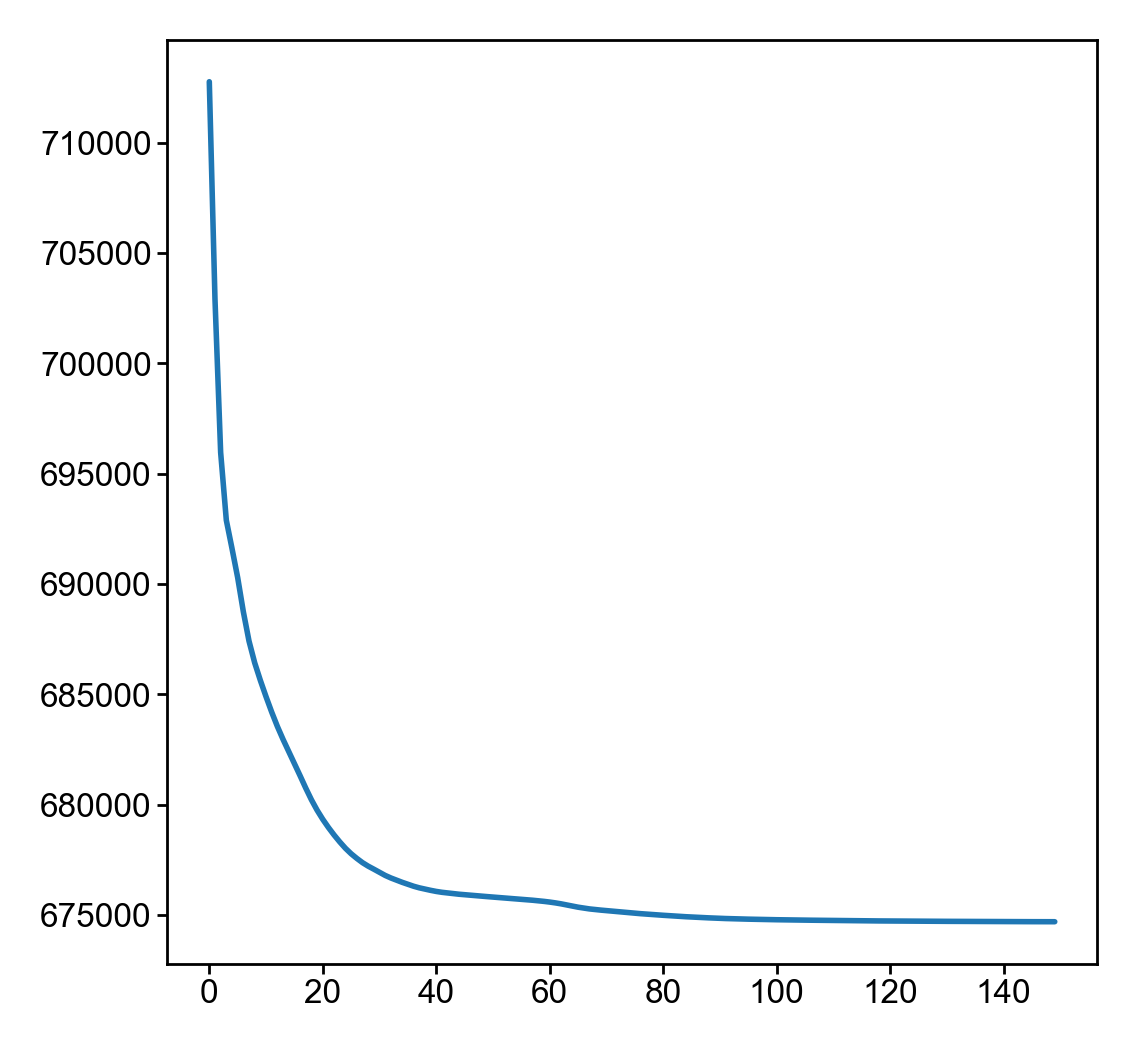

In [20]:
plt.plot(loss)

In [6]:
list(optimized_params)

['bio_basis_weights',
 'development_weights',
 'individual_biases',
 'size_basis_weights']

In [7]:
dw = optimized_params['development_weights']
age_unnormalizer(-dw[0, 1]).item()

105.91034698486328

In [ ]:
import jax
import jax.numpy as jnp
from aging.behavior.bio_age_model import raise_dim

In [9]:
bias_scale = jax.nn.sigmoid(
    optimized_params["development_weights"]
    @ jnp.stack([age_samples, jnp.ones_like(age_samples)], axis=0)
).flatten()

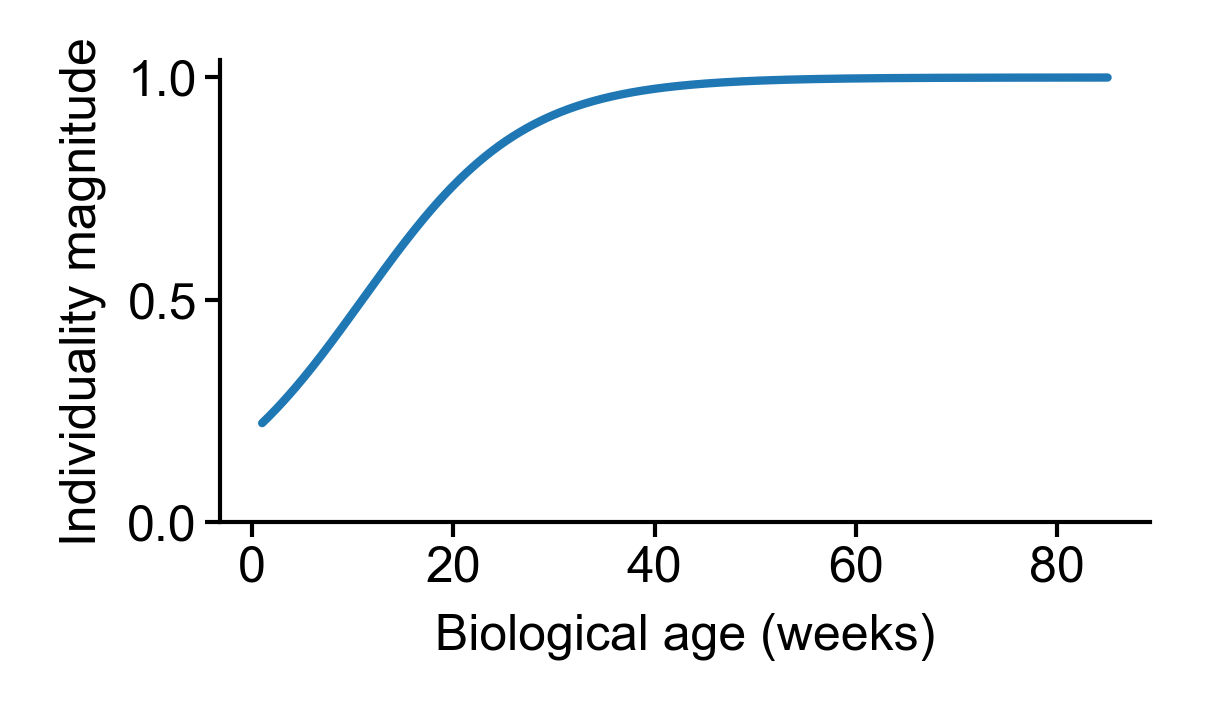

In [19]:
figure(2, 1)
plt.plot(age_unnormalizer(age_samples), bias_scale)
plt.ylim(0, None)
plt.ylabel("Individuality magnitude")
plt.xlabel("Biological age (weeks)")
sns.despine()

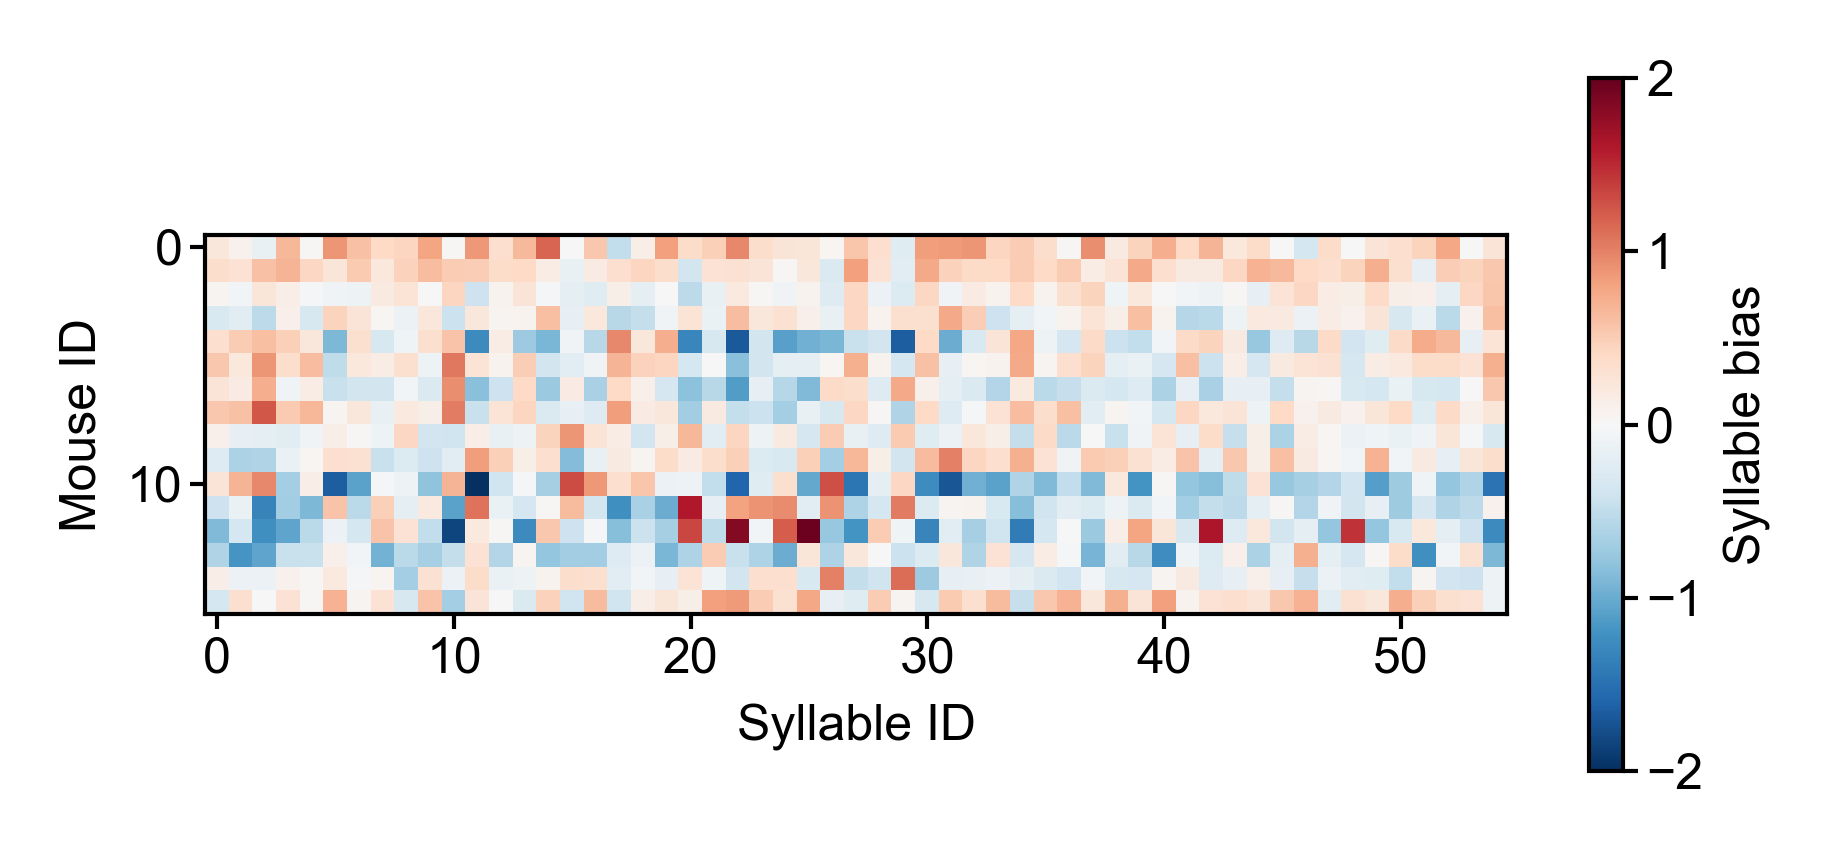

In [13]:
fig = figure(3.5, 1.5)
ax = fig.gca()
im = ax.imshow(
    raise_dim(optimized_params["individual_biases"], axis=1).T,
    cmap="RdBu_r",
    vmin=-2,
    vmax=2,
)
ax.set(xlabel="Syllable ID", ylabel="Mouse ID")
fig.colorbar(im, label="Syllable bias")